<a href="https://colab.research.google.com/github/enriquetracker/CancerDetector/blob/main/Cancer_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

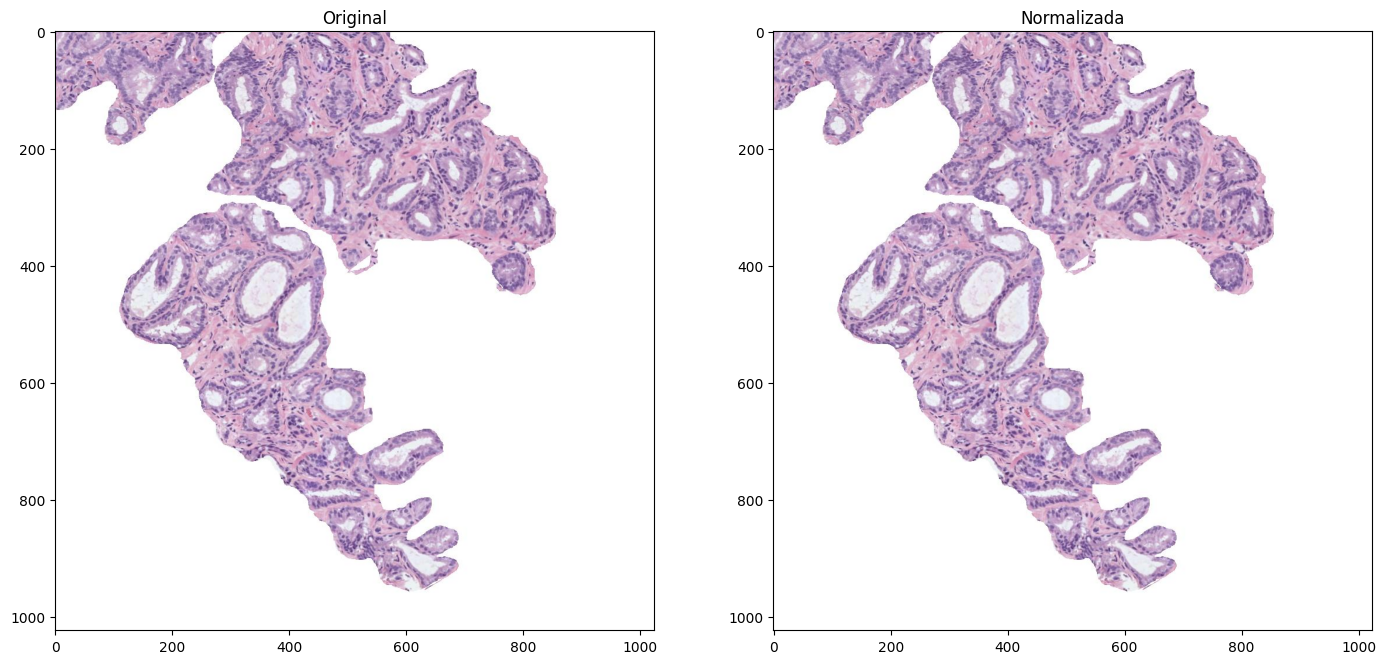

In [ ]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
from skimage import io
import matplotlib.pyplot as plt
import cv2
import numpy as np

img = io.imread('histo_2.jpg')
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
img_norm = img.astype('uint8')/255
# Visualizar la imagen
fig, ax = plt.subplots(1,2,figsize=(17,17))
ax[0].imshow(img, cmap='gray'), ax[0].set_title('Original')
ax[1].imshow(img_norm, cmap='gray'), ax[1].set_title('Normalizada')
plt.show()


#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

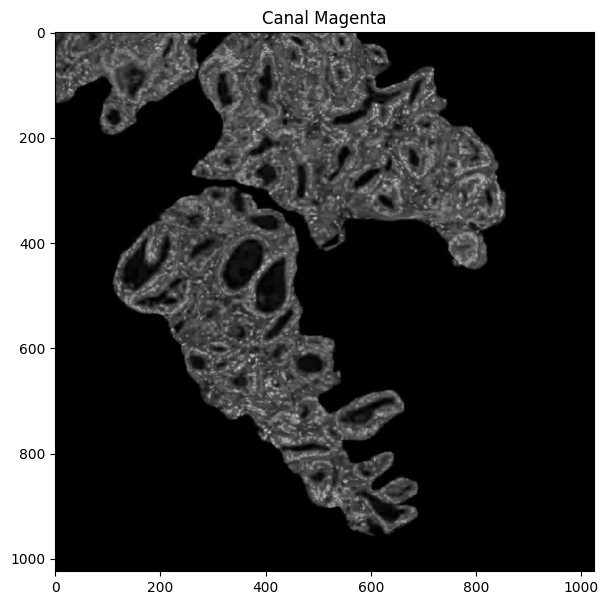

In [ ]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(img, axis=2)
    C = (1-img[:,:,0] - K)/(1-K)
    M = (1-img[:,:,1] - K)/(1-K)
    Y = (1-img[:,:,2] - K)/(1-K)

CMYK = (np.dstack((C,M,Y,K))*255).astype(np.uint8)
C,M,Y,K = cv2.split(CMYK)

# Visualizar la imagen del canal magenta

plt.figure(figsize=(7,7))
plt.title("Canal Magenta")
plt.imshow(M.astype('uint8'), cmap='gray')
plt.show()


#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

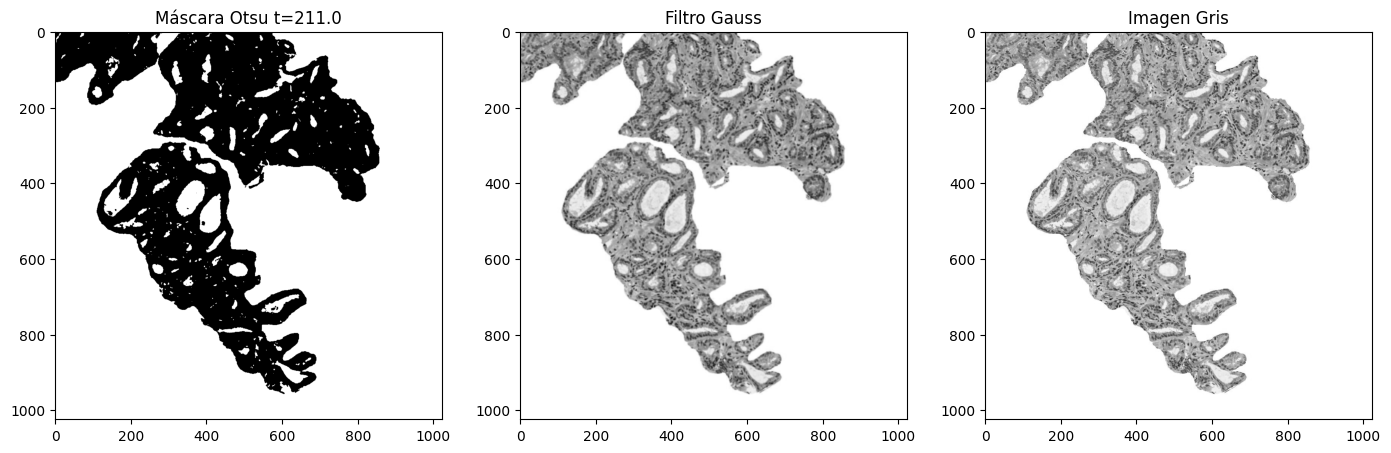

In [ ]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gaus = cv2.GaussianBlur(gray_img, (5,5), 0)
t, mask = cv2.threshold(img_gaus,0,1,cv2.THRESH_OTSU)

fig, ax = plt.subplots(1,3,figsize=(17, 17))

ax[0].imshow(mask, cmap='gray'), ax[0].set_title('Máscara Otsu t=' + str(t))
ax[1].imshow(img_gaus, cmap='gray'), ax[1].set_title('Filtro Gauss')
ax[2].imshow(gray_img, cmap='gray'), ax[2].set_title('Imagen Gris')
plt.show()


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

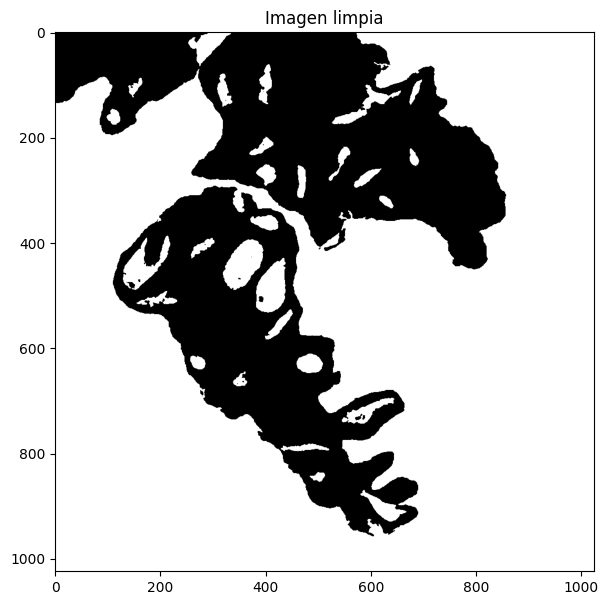

In [ ]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante
from skimage import morphology

arr = np.array(mask)> 0
mask_limpia = np.array(morphology.remove_small_objects(arr, min_size=300),int)

plt.figure(figsize=(7,7))
plt.title("Imagen limpia")
plt.imshow(mask_limpia , cmap='gray')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

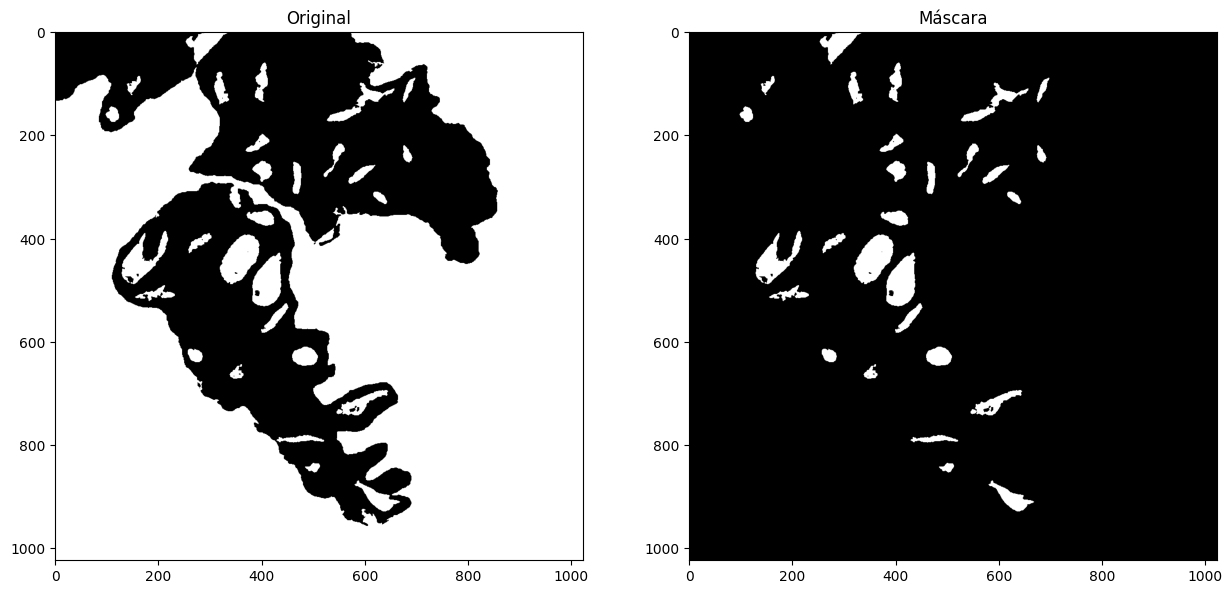

In [ ]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.
from skimage.measure import label
from skimage.measure import regionprops

lab, num = label(mask_limpia, return_num=True)
lstRelleno = []
for i in range(1,num+1):
    objeto = lab == i

    prop = regionprops(objeto.astype(np.uint8))
#Los objetos mayores de 50000 serviran como origen de la semilla
    if prop[0].area > 50000:
        lstRelleno.append(prop[0].centroid)

lstRelleno = [(int(element[0]), int(element[1])) for element in lstRelleno]
# Crear una copia de la imagen
mask_flood = mask_limpia.copy()

# Definir una imagen negra de referencia
h, w = mask.shape
ref = np.zeros((h+2, w+2), np.uint8)

for i in range(len(lstRelleno)):
# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) para rellenar a partir de ahí
    cv2.floodFill(mask_flood, ref, lstRelleno[i], 0); # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición


fig, ax = plt.subplots(1,2,figsize=(15, 15))

ax[1].imshow(mask_flood, cmap='gray'), ax[1].set_title('Máscara')
ax[0].imshow(mask_limpia, cmap='gray'), ax[0].set_title('Original')

plt.show()

#### 5) Rellenar los objetos de los lúmenes

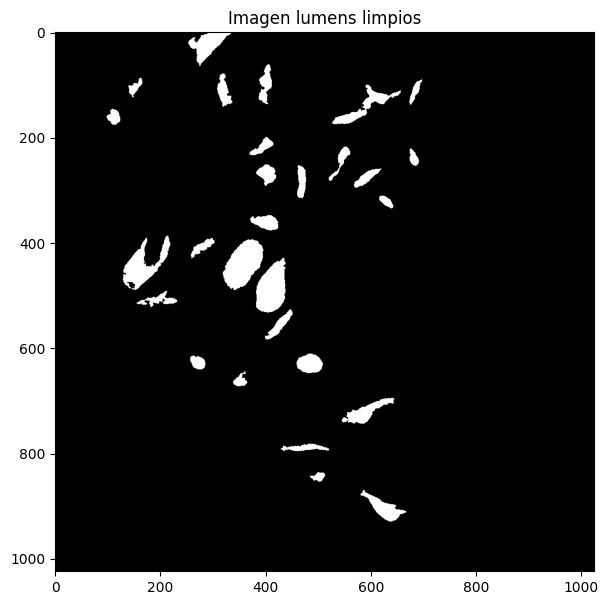

In [ ]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante
from scipy import ndimage

mask_fillholes=ndimage.binary_fill_holes(mask_flood).astype(int)

plt.figure(figsize=(7, 7))
plt.title("Imagen lumens limpios")
plt.imshow(mask_fillholes , cmap='gray')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

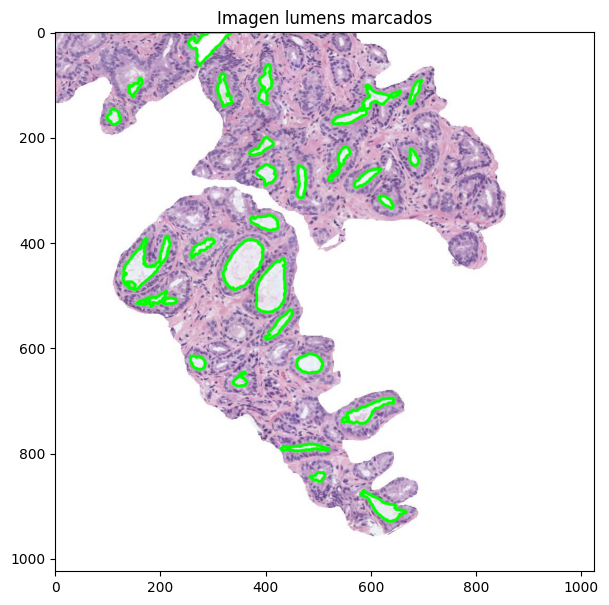

In [ ]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta
img_cont = img.copy()
contours,_ = cv2.findContours(mask_fillholes.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_cont, contours, -1, (0, 255, 0), 4, cv2.LINE_AA)

plt.figure(figsize=(7, 7))
plt.title("Imagen lumens marcados")
plt.imshow(img_cont)
plt.show()

#### 7) Identificar y cropear el lumen más grande

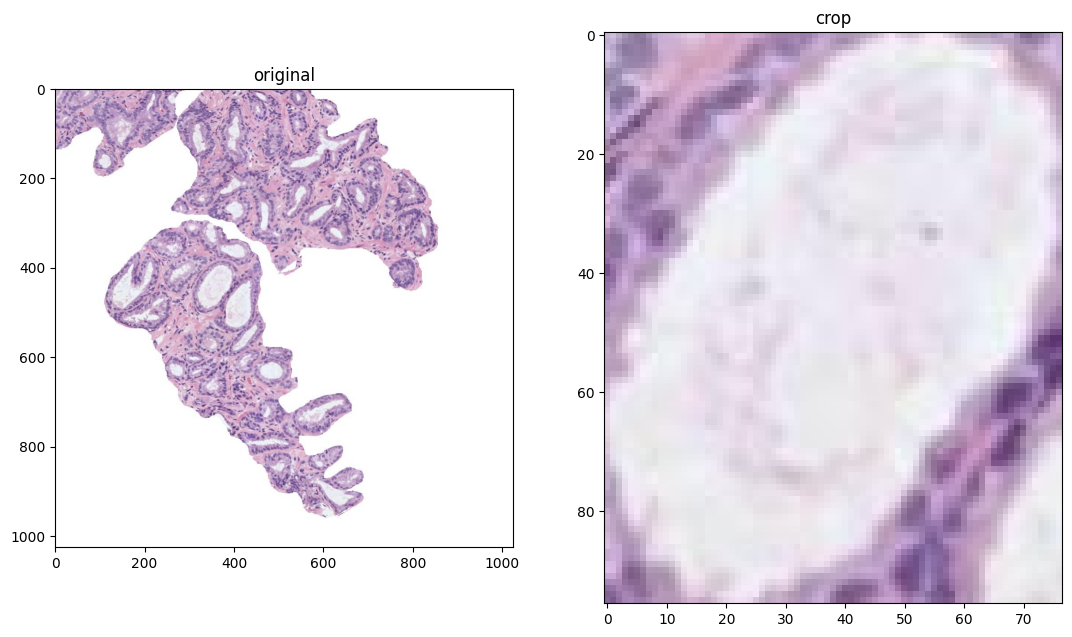

In [ ]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

lab2, num2= label(mask_fillholes, return_num=True)
area_Max=0

for i in range(1,num2+1):
    objeto = lab2 == i

    prop = regionprops(objeto.astype(np.uint8))

    if prop[0].area > area_Max:
        area_Max =  prop[0].area
        objeto_Max = objeto
        posicion_Max = prop[0].bbox

new_img = img[posicion_Max[0]:posicion_Max[2], posicion_Max[1]:posicion_Max[3]]
figs, ax = plt.subplots(1,2,figsize=(13, 13))
ax[0].imshow(img), ax[0].set_title('original')
ax[1].imshow(new_img), ax[1].set_title('crop')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [ ]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad
import math
prop = regionprops(objeto_Max.astype(np.uint8))

mensaje = 'Las propiedades del lumen de mayor area son:\n'\
        f'Area: {round(prop[0].area,4)}\n'\
        f'Área de la bounding box: {round(prop[0].area_bbox,4)}\n'\
        f'Área convexa: {round(prop[0].area_convex,4)}\n'\
        f'Exentricidad: {round(prop[0].eccentricity,4)}\n'\
        f'Diámetro equivalente: {round(prop[0].equivalent_diameter,4)}\n'\
        f'Extensión: {round(prop[0].extent,4)}\n'\
        f'Diámetro Feret: {round(prop[0].feret_diameter_max,4)}\n'\
        f'Longitud del eje mayor: {round(prop[0].major_axis_length,4)}\n'\
        f'Longitud del eje menor: {round(prop[0].minor_axis_length,4)}\n'\
        f'Orientación: {round(prop[0].orientation,4)}\n'\
        f'Perímetro: {round(prop[0].perimeter,4)}\n'\
        f'Solidez: {round(prop[0].solidity,4)}\n'\
        f'Compacidad: {round(4*math.pi*prop[0].area/prop[0].perimeter**2,4)}'

print(mensaje)

Las propiedades del lumen de mayor area son:
Area: 4691.0
Área de la bounding box: 7392.0
Área convexa: 4885.0
Exentricidad: 0.8373
Diámetro equivalente: 77.2837
Extensión: 0.6346
Diámetro Feret: 104.3168
Longitud del eje mayor: 104.789
Longitud del eje menor: 57.3004
Orientación: -0.5623
Perímetro: 287.5635
Solidez: 0.9603
Compacidad: 0.7129
